# Training of the model
## Extra lib instalation

In [0]:
!pip install speechpy
!pip install soundfile
!pip install tables
!pip install tensorflow-gpu==2.0.0-beta1
!pip install imblearn

     |████████████████████████████████| 348.9MB 64kB/s 
     |████████████████████████████████| 501kB 40.8MB/s 
     |████████████████████████████████| 3.1MB 39.0MB/s 


## Check if Google gave us the better GPU for DNN

In [0]:
!nvidia-smi

Wed Jul  3 09:38:45 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8    26W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
import pynvml

pynvml.nvmlInit()
handle = pynvml.nvmlDeviceGetHandleByIndex(0)
device_name = pynvml.nvmlDeviceGetName(handle)

if device_name != b'Tesla T4':
    raise Exception("""
    Unfortunately this instance does not have a T4 GPU.

    Please make sure you've configured Colab to request a GPU instance type.

    Sometimes Colab allocates a Tesla K80 instead of a T4. Resetting the instance.

    If you get a K80 GPU, try Runtime -> Reset all runtimes...
    """)
else:
    print('Woo! You got the right kind of GPU!')

ERROR:root:An unexpected error occurred while tokenizing input
The following traceback may be corrupted or invalid
The error message is: ('EOF in multi-line string', (1, 4))



Exception: ignored

## Lib imports

In [0]:
import numpy as np
import pandas as pd
import soundfile as sf
import scipy.io.wavfile as wav
import speechpy
import json
import os
import math
import tensorflow.keras as k
import dask.dataframe as dd
from IPython.display import display, Markdown
from time import sleep
from pprint import pprint
from multiprocessing import Queue, Process, Pool

%config IPCompleter.greedy=True

## Login to yourdrive

For audio processing I will use `speechpy` as it is the fastest of the well known libraries:

![speed_comp](https://camo.githubusercontent.com/1465ddaba9f99df4ff86ef800ef4598f35c12698/68747470733a2f2f696d61676573322e696d67626f782e636f6d2f64652f31302f6f4e5a776b49694b5f6f2e706e67)
> Source: [sonopy](https://github.com/MycroftAI/sonopy)

## Set which cols to use as X and Y + other hyper params

In [0]:
X_list = []
Y = []
HARD_MAX = 20000
path = '../data'

y_cols = [f'{side}_dim{i}' for side in 'rl' for i in range(3) ]
X_cols = ['times', 'mfcc']
# X_cols = y_cols

columns = ['name', 'time'] + X_cols + y_cols

train_vals = {
    'train_on': 'snippets',  # ['snippets', 'generator', 'generator_tpu']
    'get_data_from': 'gdrive' # ['recreate', 'gdrive', 'pc', 'local']
}

In [0]:
if train_vals['get_data_from'] == 'gdrive':
    # Run this to mount your Google Drive.
    from google.colab import drive
    from google.colab import auth
    from googleapiclient.discovery import build
    from googleapiclient.http import MediaIoBaseDownload

    drive.mount('/content/drive')

    auth.authenticate_user()
    drive_service = build('drive', 'v3')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


W0703 22:24:49.502194 140389865355136 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0 or google-auth
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 37, in <module>
    from oauth2client.locked_file import Lock

## Processing function for dataset creation

In [0]:
def df_col2numpy(df, col_names):
    ser = df.apply(lambda row: np.array([row[col] for col in col_names]).flatten(), axis=1)
    arr = np.array(ser.values.tolist())
    return arr

def df_col2series(df, col_names):
    if len(col_names) == 1:
        ser = df[col_names[0]].map(lambda cell: np.array([cell]).flatten())
    ser = df.apply(lambda row: np.array([row[col] for col in col_names]).flatten(), axis=1)
    return ser

def file2mfcc(file_name, frame_length=0.20, frame_stride=0.1, recreate=False):
    """ recreate: whether to recreate existing .npy MFCC"""
    
    dir_name = file_name[:file_name.index('blocks')]
    file_wav, file_ogg = None, None
    
#     check for existing .mfcc cache
    for file in os.listdir(dir_name):
        if file.endswith('.mfcc') and not recreate:
            return pd.read_hdf((os.path.join(dir_name, file)))
            
#     if none .wav found, create it
    for file in os.listdir(dir_name):
        if file.endswith('.ogg'):
            file_ogg = os.path.join(dir_name, file)
            if not file_wav:
                data, samplerate = sf.read(file_ogg)
                file_wav = f'{file_ogg[:-4]}.wav'
                sf.write(file_wav, data, samplerate)

    fs, signal = wav.read(file_wav)
    
#     Stereo to mono
    if signal.shape[1] == 2:
        signal = (signal[:, 0] + signal[:, 1]) / 2
    else:
        signal = signal[:, 0]

    # Pre-emphasize
    signal_preemphasized = speechpy.processing.preemphasis(signal, cof=0.98)

    # Extract MFCC features
    mfcc = speechpy.feature.mfcc(signal, sampling_frequency=fs, frame_length=frame_length, 
                                 frame_stride=frame_stride, num_filters=40, fft_length=512,
                                 low_frequency=0, high_frequency=None, num_cepstral=13)
    
#     Normalize
    mfcc_cmvn = speechpy.processing.cmvnw(mfcc,win_size=301,variance_normalization=True)
    
#     Cache results and clean .wav to save space
#     np.save(f'{file_wav[:-4]}.mfcc.npy', mfcc_cmvn)
    if file_ogg:
        os.remove(file_wav)

#     Recalculate the time differences
    index = np.arange(0, (len(mfcc) - 0.5) * frame_stride, frame_stride) + frame_length
    df = pd.DataFrame(data=mfcc_cmvn, index=index).apply(np.array, axis=1)
    df.to_hdf(f'{file_wav[:-4]}.mfcc', 'mfcc', mode='w', format='fixed')
    return df

def process_cell(cell, side):
    res = cell[:, :, side, :]
    
    mx = res.max()
    mx_index = np.unravel_index(res.argmax(), res.shape)
    pred = [None for _ in range(3)]
    
    for dim in range(3):
#         pred[dim] = np.zeros(res.shape[dim] + 1)
        pred[dim] = np.zeros(res.shape[dim])
        
        if mx < 0.5:
#             pred[dim][-1] = 1
            pass
        else:
            pred[dim][mx_index[dim]] = 1
    
    if mx < 0.5:
        res = cell[:, :, (side+1) % 2, :]
    
        mx = res.max()
        mx_index = np.unravel_index(res.argmax(), res.shape)
        for dim in range(3):
            pred[dim][mx_index[dim]] = 1
        
    return pred

def change_output(df: pd.DataFrame):
    left, right = df.apply(lambda cell: process_cell(cell, 0)), df.apply(lambda cell: process_cell(cell, 1))
    
    left = pd.DataFrame(left.to_list(), columns=[f'l_dim{x}' for x in range(3)], index=left.index)
    right = pd.DataFrame(right.to_list(), columns=[f'r_dim{x}' for x in range(3)], index=right.index)
    
    return left.join(right)
    
def process_file(file_path, recreate=False):
    """ Processing needed to be done per file """
    print(f'Processing {file_path}')
    try:
        df = pd.read_pickle(file_path)
    
        # all in one serialization (99.5 % with bad metric)
        #     df['output'] = df_col2series(df, ['output'])
        df = df.join(change_output(df['output']))
        df['shifted'] = df['output'].shift(1, fill_value=[np.zeros(df['output'].iloc[0].shape)])
        
        df['times'] = df_col2series(df, ['prev', 'next'])
        df['name'] = f'{file_path}'

        mfcc = file2mfcc(file_path, recreate=recreate)
        mfcc.name = 'mfcc'
        round_index = mfcc.index.values[1] - mfcc.index.values[0]
        df.index = np.floor(df['time'] / round_index).astype(int)
        mfcc.index = (mfcc.index / round_index).astype(int)

        df = df.join(mfcc)
        df.index = df['time']
        df = df.dropna()
    except Exception as e:
        print(f'Caught Error: {e}')
        return None

    return df

def process_df(df, X_cols, y_cols):
    """ Post processing on the whole DF """
    
    # Add shifter y (predictions)
    y_cols_shifted = [f'{x}_shifted' for x in y_cols]
    shifted = df[y_cols].groupby('name').shift(1)
    df[y_cols_shifted] = shifted
    df = df.dropna()
    
    return df
    
# file = '../data/Army Of The Night/blocks/Expert.pkl'
# file2mfcc(file, recreate=False)
# process_file(file).iloc[0]

## Generate urls to blocks

In [0]:
def get_file_paths(path, hard_max):
    """ 
    Create a list of all pregenerated blocks files 
    Search in full subtree of :path:
    """
    
    file_paths = []
    counter = 0
    
    for root, dirs, files in os.walk(path, topdown=False):
        if counter > hard_max:
                break
        for name in files:
            if root[-6:] == 'blocks':
                print(f'#{counter:5} {root}/{name}')
                file_paths.append(os.path.join(root, name))
                
                counter += 1
                
    return file_paths

## Create and save training data

In [0]:
if train_vals['get_data_from'] == 'recreate':
    multi_core = True
    if multi_core:
        # Embarrassingly parallel problem, but RAM heavy
        pool = Pool(processes=None)
        X_list = pool.map(process_file, get_file_paths(path, HARD_MAX))
        pool.close()
        pool.join()
    else:
        X_list = [process_file(x) for x in get_file_paths(path, HARD_MAX)]

    X_list = [x for x in X_list if x is not None]

    print(f'Passes {len(X_list):6}/{HARD_MAX:6} hard max')
    X = pd.DataFrame(pd.concat(X_list), columns=columns)
    X = X.set_index(['name', 'time'])
    X = process_df(X, X_cols, y_cols)

    X.to_pickle(os.path.join(path, 'X_saved.pkl'))

## Load training data

### Load from gDrive

In [0]:
if train_vals['get_data_from'] == 'gdrive':
    # https://drive.google.com/open?id=1F9dpOELfSUJ_U_KMp3oK79h7sPM8ffbY
    file_id = '1F9dpOELfSUJ_U_KMp3oK79h7sPM8ffbY'

    import io

    request = drive_service.files().get_media(fileId=file_id)
    downloaded = io.BytesIO()
    downloader = MediaIoBaseDownload(downloaded, request)
    done = False

    while done is False:
    # _ is a placeholder for a progress object that we ignore.
        _, done = downloader.next_chunk()
    
    downloaded.seek(0)

    # pd.read_table(downloaded, sep=',', index_col=False, error_bad_lines=False, encoding='utf-8')
    X = pd.read_pickle(downloaded, compression='zip')

### Load from PC

In [0]:
if train_vals['get_data_from'] == 'pc':
    from google.colab import files

    uploaded = files.upload()

    for fn in uploaded.keys():
        print('User uploaded file "{name}" with length {length} bytes'.format(
            name=fn, length=len(uploaded[fn])))

### Load from local

In [0]:
if train_vals['get_data_from'] == 'local':
    X = pd.read_pickle(os.path.join(path, 'X_saved.pkl'))
    print(f'Loaded {len(X)} rows')

# Training approaches

## Generator training approach

### Advantages
- Every batch can have different length
    - No crop of songs in batches needed
    - Minimal padding
    - $\Rightarrow$ model learns from songs with the context of beginning and end
    
### Disadvantages
- Less convinient then standard `model.fit(X, y, **kwargs)`
- Big memory movement overhead
    - Would be even more significant if trained on a GPU
    

## Standard training approach
- Different lengths solved by generating snippets of songs of len $N$
    - Effectively creates more versitile dataset, since songs are "starting" at different places
    
### Advantages
- No padding and no crop
    - No crop of songs in batches needed
    - Minimal padding
    - $\Rightarrow$ model learns from songs with the context of beginning and end
- All "heavy altilery" from TF can be used
    
### Disadvantages
- No differentitation between beggining and end of the song
    - $\Rightarrow$ could be solved by adding procentage column which indicates in interval $(0, 1)$ where the beat lies in the song

# Generator training approach
## Helper functions for train_generator

In [0]:
precision = 2

def pp(row):
    print('*' * 69)
    print(row)
    
def round_up(num:float, prec: int) -> int:
    return int(math.ceil((10 ** -prec) * num) / (10 ** -prec))
    
def get_len_category(song, prec: int=precision):
    return int(round_up(len(song), 2))

def get_mask(X, prec: int=precision):
    mask = X.groupby('name').apply(get_len_category)
    return mask.to_dict()

def create_batch(group, ceil_len, verbose=True):
    if verbose:
        print(f'Creating batch of ceil_len {ceil_len:6} with {len(group)} rows')
    ceil_len = int(ceil_len)
    
    batch = []
    for name, song in group.groupby('name'):
        empty_row = song.head(1).squeeze().apply(np.zeros_like)
#         print(f'{ceil_len} | {len(song)} | {empty_row}')
        df_to_add = pd.DataFrame([empty_row] * (ceil_len - len(song)))
        batch.append(pd.concat([song, df_to_add]))

    return pd.concat(batch)

# LESON: Don't forget about the NaNs!


def list2numpy(batch, col_name, groupby=('name')):
    return np.array(batch.groupby(list(groupby))[col_name].apply(list).to_list())

## Show bucketing results

In [0]:
if train_vals['train_on'] == 'generator':
    grouped = X.groupby(get_mask(X), level=0)

    adjust = 6
    stats = []
    print(f'{"from":>{adjust}} ‒ {"to":>{adjust}}: {"# of songs":>{adjust*2}}')

    for name, group in grouped:
        print(f'{name - 10 ** precision:{adjust}} ‒ {name:{adjust}}: {len(group.groupby("name").groups):{adjust*2}}')
        stats.append({'from': name - 10 ** precision, 'to': name, '# of songs': len(group.groupby("name").groups)})

    # print in your favorite way
    # pd.DataFrame(stats, columns=['from', 'to', '# of songs'])

In [0]:
def train_generator(df, X_cols, y_cols, verbose=True):
    grouped = X.groupby(get_mask(df), level=0)
    
#     p = Pool(2)  # slowe because of memory
#     batches = p.starmap(create_batch, [(group, ceil_len) for ceil_len, group in grouped])
#     grouped = list(grouped)[:2]
    batches = [create_batch(group, ceil_len, verbose) for ceil_len, group in grouped]
    batches = [batch for batch in batches if len(batch.groupby('name').groups) > 8]
    
    while True:
        for batch in batches:
            yield [list2numpy(batch, col) for col in X_cols],\
                  [list2numpy(batch, col) for col in y_cols]
            
if train_vals['train_on'] == 'generator':
    # test generated shapes
    generator = train_generator(X, X_cols, y_cols)
    for x, y in generator:
        print(f'x.shapes {[np.array(x_t).shape for x_t in x]}')
        print(f'y.shape {[np.array(y_t).shape for y_t in y]}\n')
        break

# Model

In [0]:
from tensorflow.keras.layers import Dense, LSTM, Flatten, Input, Activation, TimeDistributed, concatenate, Dropout, GRU, SimpleRNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import top_k_categorical_accuracy
from tensorflow.keras import optimizers
import tensorflow.keras.backend as K

In [0]:
def get_model(X, X_cols, y_cols, settings=None, input_length=None, batch_size=None):
    rnn_fn = {
        'rnn': SimpleRNN,
        'gru': GRU,
        'lstm': LSTM
    }
    
    opt_fn = {
        'adam': optimizers.Adam,
        'rmsprop': optimizers.RMSprop,
    }
  
    if not settings:
        settings = {
            'pre_process': 0.5,
            'pre_process_f': 'sigmoid',

            'rnn_join':[0, 32],
            'fn_join': 'lstm',
            'drop_join': 0,

            'rnn_split':[0, 32],
            'fn_split': 'lstm',
            'drop_split': 0,

            'optimizer': 'adam',
            'lr': 0.005,
        }
        
    stateful = batch_size is not None
    
    demo_row = X.iloc[0]
    X_shapes = [demo_row[col].shape[0] for col in X_cols]
    y_shapes = [demo_row[col].shape[0] for col in y_cols]
    
    inputs = [Input(batch_size=batch_size, shape=(input_length, shape)) for shape in X_shapes]
    
    if int(settings['pre_process']) != 0:
        time_dist = [TimeDistributed(Dense(int(shape * settings['pre_process']), activation=settings['pre_process_f']))(inputs[i])
                     for i, shape in enumerate(X_shapes)]
    else:
        time_dist = inputs
    
    join = concatenate(time_dist, axis=-1)
      
    for h_size in settings['rnn_join']:
        if h_size != 0:
            split = rnn_fn[settings['fn_join']](h_size, return_sequences=True, dropout=settings['drop_join'], stateful=stateful)(join)
    
    split = None
    for h_size in settings['rnn_split']:
        if h_size != 0:
            if not split:
                split = [rnn_fn[settings['fn_split']](h_size, return_sequences=True, dropout=settings['drop_split'], stateful=stateful)(join) for i, col in enumerate(y_cols)]
            else:
                split = [rnn_fn[settings['fn_split']](h_size, return_sequences=True, dropout=settings['drop_split'], stateful=stateful)(split[i]) for i, col in enumerate(y_cols)]
    
    if split:
        outputs = [TimeDistributed(Dense(shape, activation='softmax'), name=col)(split[i]) 
                   for i, (shape, col) in enumerate(zip(y_shapes, y_cols))]
    else:
        outputs = [TimeDistributed(Dense(shape, activation='softmax'), name=col)(join) for shape, col in zip(y_shapes, y_cols)]

    model = Model(inputs=inputs, outputs=outputs)
    
    model.compile(optimizer=opt_fn[settings['optimizer']](lr=settings['lr']),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model


model = get_model(X, X_cols, y_cols, input_length=None, batch_size=32)
model.summary()


Model: "model_31"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_67 (InputLayer)           [(32, None, 2)]      0                                            
__________________________________________________________________________________________________
input_68 (InputLayer)           [(32, None, 13)]     0                                            
__________________________________________________________________________________________________
concatenate_33 (Concatenate)    (32, None, 15)       0           input_67[0][0]                   
                                                                 input_68[0][0]                   
__________________________________________________________________________________________________
lstm_124 (LSTM)                 (32, None, 32)       6144        concatenate_33[0][0]      

## Get a new model and show it

In [0]:
X.columns


In [0]:
model = get_model(X, X_cols, y_cols)
model.summary()

## Train model on generator

In [0]:
def important_metric(metric_name):
    return 'val' in metric_name and 'acc' in metric_name
        

def train_on_generator(X, X_cols, y_cols, verbose_level=1, model=None, epochs=300):
    if not model:
        model = get_model(X, X_cols, y_cols)
    
    acc_results = {}
    stats_len = 30

    generator = train_generator(X, X_cols, y_cols, verbose_level>=2)
    for i, (x, y) in enumerate(generator):
        if i > epochs:
            break
        res = model.fit(x, y, batch_size=128, validation_split=0.1, verbose=verbose_level>=3)
        
        if verbose_level >= 1:
            if i % stats_len == 0:
                total_acc = (np.array(list(acc_results.values())) / stats_len).mean()
                display(Markdown(f'### Batch {i:4} | {total_acc:4.4}'))
                pprint([f'{key:30}: {val/stats_len}' for key, val in acc_results.items()])

                acc_results = {key: val[0] for key, val in res.history.items() if important_metric(key)}
            else:
                for key in acc_results:
                    acc_results[key] += res.history[key][0]
    
    
    acc_results = {key: val[0] for key, val in res.history.items() if important_metric(key)}
    total_acc = (np.array(list(acc_results.values()))).mean()
    display(Markdown(f'### Last epoch {i:4} results | {total_acc:4.4}'))
    pprint(acc_results)
    
    return model
    
# Test train_on_generator
# train_on_generator(X, X_cols, y_cols, 2, None, 2)

In [0]:
if train_vals['train_on'] == 'generator':
    train_on_generator(X, y_cols, y_cols, verbose_level=1, model=None, epochs=300)

    model = train_on_generator(X, ['times', 'mfcc'] + y_cols_shifted, y_cols, verbose_level=2, model=model, epochs=490)

### Empirical findings
- If the `y_cols_shifted` input is not provided, model tends to learn and stay on most common value of each classification.
- Sanity check porforms quickly over 90 % acc

### Improvements to be tested

1. More normalization of the data
    - Force the model to catch the underlying principle and not "mean"
1. Flip L / R hand and horizontal mirorring and rotations
1. Flip vertically with rotation
1. If one hand not used, mirror the other hand instead of "0"
1. Instead of generator, create snippets of 100 beats
    - Easier GPU training
    - Train it on gColab

## Hand evaluation
- Is needed since good results can be caused by a wrongly chosen matric!

In [0]:
if train_vals['train_on'] == 'generator':
    import copy

    generator = train_generator(X, ['times', 'mfcc'] + y_cols_shifted, y_cols)
    x, y = generator.__next__()
    prediction = model.predict(x)

In [0]:
if train_vals['train_on'] == 'generator':
    f, t = 0, 20
    for dim, (p, y_t) in enumerate(zip(prediction, y)):    
        df = pd.DataFrame(p[0][f:t])
        df = df.eq(df.where(df != 0).max(1), axis=0).astype(int)
        df.index.name = y_cols[dim]
        df_y = pd.DataFrame(y_t[0][f:t]).astype(int)
        df = df.join(df_y, rsuffix='_true')
        display(df)

In [0]:
def eval_generator():
    while True:
        for x1, x2, y in zip(X['blocks'][300:], X['times'][300:], Y[300:]):
            yield [np.array([x1, ]), np.array([x2, ])], np.array([y, ])
           
if train_vals['train_on'] == 'generator':
    model = get_model()
    model.batch_size = 8            

    model.fit_generator(train_generator(), steps_per_epoch=300, epochs=1, verbose=1, 
                      use_multiprocessing=False)
    model.evaluate_generator(eval_generator(), steps=19, )

## Add shifted outputs

In [0]:
X = process_df(X, X_cols, y_cols)
X.columns
X_cols += ['r_dim0_shifted', 'r_dim1_shifted', 'r_dim2_shifted',
       'l_dim0_shifted', 'l_dim1_shifted', 'l_dim2_shifted']
X_cols, y_cols

# Song snippets training

In [0]:
def generate_snippets(song_df, window=100, skip=50):
    stack = []
    ln = len(song_df)
    
    # Check if at least 1 window is possible
    if ln < window:
        return None
    
    # name information is contained in the grouping operation
    song_df = song_df.reset_index(level='name').drop(columns='name')

    for s in range(0, ln, skip):
        # Make sure the dataset contains ends of the songs
        if s + window > ln:
            stack.append(song_df.iloc[-window:])
        else:
            stack.append(song_df.iloc[s:s+window])
    
    df = pd.concat(stack, keys=list(range(0, len(song_df), skip)), names=['snippet', 'time'])
    return df
    
X = process_df(X, X_cols, y_cols)
X2 = X.iloc[:].groupby('name').apply(generate_snippets)


In [0]:
X_cols

['times', 'mfcc']

In [0]:
def create_training_data(X, groupby=('name', 'snippet')):
    return [list2numpy(X, col, groupby) for col in X_cols],\
           [list2numpy(X, col, groupby) for col in y_cols]

x, y = create_training_data(X2)

In [0]:
X2.iloc[0]

times                                              [0.5625, 0.5625]
mfcc              [0.1203609, 0.8934802, -0.27877954, -0.6908295...
r_dim0                                              [1.0, 0.0, 0.0]
r_dim1                                         [0.0, 0.0, 0.0, 1.0]
r_dim2                [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
l_dim0                                              [1.0, 0.0, 0.0]
l_dim1                                         [0.0, 0.0, 1.0, 0.0]
l_dim2                [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
r_dim0_shifted                                      [1.0, 0.0, 0.0]
r_dim1_shifted                                 [0.0, 0.0, 0.0, 1.0]
r_dim2_shifted        [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
l_dim0_shifted                                      [1.0, 0.0, 0.0]
l_dim1_shifted                                 [0.0, 0.0, 1.0, 0.0]
l_dim2_shifted        [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Name: (../data/1000 Cuts/blocks/Expert.pkl, 0, 3

## Train utils
- Let's search for good hyperparameters!

In [0]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard
from time import time
import datetime
from pprint import pprint
from itertools import product


def get_callbacks(settings):
    train_name = str(settings)
    return [
        EarlyStopping('val_loss', min_delta=0.0008, patience=7),
#         EarlyStopping('val_loss', min_delta=0.008, patience=4),
        ReduceLROnPlateau('val_loss', patience=2, factor=0.2, min_lr=0.0001),
#         TensorBoard(log_dir=f'./logs/{train_name}'),
    ]

train_settings = {}

# Pre RNN
train_settings['pre_process'] = [0, 0.5, 1, 2]
train_settings['pre_process_f'] = ['elu', 'sigmoid']

# RNN
layers_op = [0, 16, 24, 32]  # potentially add 64, 128
for part in ['join', 'split']:
    train_settings[f'rnn_{part}'] = list(product(layers_op, repeat=2))
    train_settings[f'drop_{part}'] = [0, 0.1, 0.2]
    train_settings[f'fn_{part}'] = ['gru', 'lstm']  # rnn is too slow
    
# Compilation
train_settings['optimizer'] = ['adam', 'rmsprop']
train_settings['lr'] = [0.03, 0.01, 0.005, 0.001]


p = product(*list(train_settings.values()))
train_settings_df = pd.DataFrame(p, columns=list(train_settings.keys()))
train_settings_df.head()

,pre_process,pre_process_f,rnn_join,drop_join,fn_join,rnn_split,drop_split,fn_split,optimizer,lr
0,0.0,elu,"(0, 0)",0.0,gru,"(0, 0)",0.0,gru,adam,0.030
1,0.0,elu,"(0, 0)",0.0,gru,"(0, 0)",0.0,gru,adam,0.010
2,0.0,elu,"(0, 0)",0.0,gru,"(0, 0)",0.0,gru,adam,0.005
3,0.0,elu,"(0, 0)",0.0,gru,"(0, 0)",0.0,gru,adam,0.001
4,0.0,elu,"(0, 0)",0.0,gru,"(0, 0)",0.0,gru,rmsprop,0.030


In [0]:
for i, row in train_settings_df.sample(10).iterrows():
    print(row.to_dict())
    
print(f'Total comb size: {len(train_settings_df)}')

{'pre_process': 0.0, 'pre_process_f': 'elu', 'rnn_join': (24, 32), 'drop_join': 0.1, 'fn_join': 'lstm', 'rnn_split': (24, 24), 'drop_split': 0.0, 'fn_split': 'gru', 'optimizer': 'rmsprop', 'lr': 0.01}
{'pre_process': 2.0, 'pre_process_f': 'sigmoid', 'rnn_join': (16, 0), 'drop_join': 0.1, 'fn_join': 'lstm', 'rnn_split': (24, 32), 'drop_split': 0.2, 'fn_split': 'gru', 'optimizer': 'rmsprop', 'lr': 0.005}
{'pre_process': 2.0, 'pre_process_f': 'sigmoid', 'rnn_join': (24, 16), 'drop_join': 0.2, 'fn_join': 'gru', 'rnn_split': (24, 32), 'drop_split': 0.2, 'fn_split': 'lstm', 'optimizer': 'adam', 'lr': 0.001}
{'pre_process': 0.0, 'pre_process_f': 'elu', 'rnn_join': (16, 32), 'drop_join': 0.1, 'fn_join': 'lstm', 'rnn_split': (0, 0), 'drop_split': 0.2, 'fn_split': 'gru', 'optimizer': 'rmsprop', 'lr': 0.001}
{'pre_process': 0.0, 'pre_process_f': 'elu', 'rnn_join': (0, 0), 'drop_join': 0.0, 'fn_join': 'gru', 'rnn_split': (0, 16), 'drop_split': 0.1, 'fn_split': 'gru', 'optimizer': 'adam', 'lr': 0.0

In [0]:
# !ls "/content/drive/My Drive/Programování - projekty a práce/ArtificialDot/Colabs/DeepSaber"

path_for_results = '/content/drive/My Drive/Programování - projekty a práce/ArtificialDot/Colabs/DeepSaber/results.csv'

def reset_results():
    results_df = pd.DataFrame(columns=['settings',
                                        'val_loss',
                                        'val_l_dim0_accuracy',
                                        'val_l_dim1_accuracy',
                                        'val_l_dim2_accuracy',
                                        'val_r_dim0_accuracy',
                                        'val_r_dim1_accuracy',
                                        'val_r_dim2_accuracy',
                                        'val_l_dim0_loss',
                                        'val_l_dim1_loss',
                                        'val_l_dim2_loss',
                                        'val_r_dim0_loss',
                                        'val_r_dim1_loss',
                                        'val_r_dim2_loss',
                                        'loss',
                                        'l_dim0_accuracy',
                                        'l_dim1_accuracy',
                                        'l_dim2_accuracy',
                                        'r_dim0_accuracy',
                                        'r_dim1_accuracy',
                                        'r_dim2_accuracy',
                                        'l_dim0_loss',
                                        'l_dim1_loss',
                                        'l_dim2_loss',
                                        'r_dim0_loss',
                                        'r_dim1_loss',
                                        'r_dim2_loss',
                                        'lr',
                                      ])
    results_df.index.rename('id', inplace=True)
#     results_df = results_df.append({'settings': 'Test'}, ignore_index=True)
    results_df.to_csv(path_for_results)
    
# reset_results()

In [0]:
try:
    results_df = pd.read_csv(path_for_results, index_col='id')
except ValueError as e:
    print(e)
    results_df = pd.read_csv(path_for_results).set_index('Unnamed: 0')
    results_df.index.name = 'id'
    results_df.to_csv(path_for_results, index_label='id')
results_df['elapsed'].mean()


524.4864634112204

## Dealocate memory

In [0]:
# Dealocate memory
X = X.iloc[:10]
X2 = None

import gc
gc.collect()

1165

## Train on different architectures and hyperparams and save results to a csv
- CSV is safely in a gDrive => access to results outside of this instance

In [0]:
def subset_list(list_, split_ratio, base):
    sectors = len(list_[0]) // base
    split = int(sectors * split_ratio) * base
    end = sectors * base
    
    return [x[:split] for x in list_], [x[split:end] for x in list_], [x[end:] for x in list_]

In [0]:
from time import time

model_path = '/content/drive/My Drive/Programování - projekty a práce/ArtificialDot/Colabs/DeepSaber/model.h5'
results_df = pd.read_csv(path_for_results, index_col='id')

display(results_df.tail())
batch_size = 256

x_t, x_v, _ = subset_list(x, 0.8, batch_size)
y_t, y_v, _ = subset_list(y, 0.8, batch_size)

for i, row in train_settings_df.sample(1000).iterrows():
    settings = row.to_dict()
    
    print(f'Working on: {settings}')
    model = get_model(X, X_cols, y_cols, settings, input_length=100, batch_size=None)

    start = time()
    
#     Statefull
#     h = model.fit(x_t, y_t, batch_size=batch_size, epochs=150, validation_data=(x_v, y_v), callbacks=get_callbacks(settings), verbose=False, shuffle=False)
    
#     Not statefull
    h = model.fit(x_t, y_t, batch_size=batch_size, epochs=150, validation_data=(x_v, y_v), callbacks=get_callbacks(settings), verbose=False, shuffle=True)
    
    settings['batch_size'] = batch_size
    mvloss_index = h.history['val_loss'].index(min(h.history['val_loss']))
    
    top_val_loss = {k: v[mvloss_index] for k, v in h.history.items()}
    top_val_loss['settings'] = settings
    top_val_loss['elapsed'] = time() - start
        
    results_df = results_df.append(top_val_loss, ignore_index=True)
    try:
        display(results_df.iloc[-1].to_frame().T)
    except Exception:
        pass
    
    results_df.to_csv(path_for_results, index_label='id')

,settings,val_loss,val_l_dim0_accuracy,val_l_dim1_accuracy,val_l_dim2_accuracy,val_r_dim0_accuracy,val_r_dim1_accuracy,val_r_dim2_accuracy,val_l_dim0_loss,val_l_dim1_loss,val_l_dim2_loss,val_r_dim0_loss,val_r_dim1_loss,val_r_dim2_loss,loss,l_dim0_accuracy,l_dim1_accuracy,l_dim2_accuracy,r_dim0_accuracy,r_dim1_accuracy,r_dim2_accuracy,l_dim0_loss,l_dim1_loss,l_dim2_loss,r_dim0_loss,r_dim1_loss,r_dim2_loss,lr,elapsed
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
293,"{'pre_process': 0.0, 'pre_process_f': 'sigmoid...",7.859069,0.717617,0.308374,0.351241,0.715868,0.313576,0.350583,0.756314,1.362892,1.810183,0.758259,1.361045,1.810376,7.772352,0.720452,0.320980,0.362015,0.718798,0.325219,0.361641,0.746805,1.355003,1.783641,0.749133,1.353813,1.783957,0.005,64.765165
294,"{'pre_process': 2.0, 'pre_process_f': 'sigmoid...",7.832007,0.717632,0.309570,0.359384,0.715871,0.314841,0.358083,0.755399,1.360731,1.799265,0.756035,1.360190,1.800387,7.790599,0.720443,0.319628,0.361351,0.718791,0.323055,0.360691,0.749091,1.356064,1.789778,0.750462,1.354754,1.790449,0.005,105.794477
295,"{'pre_process': 2.0, 'pre_process_f': 'elu', '...",7.806442,0.717653,0.310892,0.363993,0.715871,0.314862,0.362245,0.752658,1.359282,1.790157,0.754562,1.358143,1.791639,7.750645,0.720456,0.323750,0.367909,0.718783,0.325690,0.367303,0.744180,1.353465,1.777939,0.746235,1.351632,1.777194,0.006,122.205487
296,"{'pre_process': 0.0, 'pre_process_f': 'sigmoid...",7.883160,0.717632,0.303194,0.335892,0.715871,0.309306,0.334727,0.756192,1.364213,1.820860,0.758192,1.362752,1.820951,7.835722,0.720439,0.311390,0.340331,0.718797,0.315871,0.339798,0.751780,1.360986,1.804733,0.753028,1.359561,1.805633,0.006,68.505830
297,"{'pre_process': 0.0, 'pre_process_f': 'sigmoid...",7.851960,0.717632,0.308915,0.352533,0.715871,0.310676,0.352181,0.756136,1.361915,1.806289,0.757457,1.360788,1.809376,7.802516,0.720443,0.315555,0.358983,0.718791,0.319916,0.358444,0.749591,1.358665,1.791855,0.750879,1.357567,1.793958,0.010,56.084639


Working on: {'pre_process': 0.5, 'pre_process_f': 'elu', 'rnn_join': (24, 16), 'drop_join': 0.1, 'fn_join': 'lstm', 'rnn_split': (0, 24), 'drop_split': 0.0, 'fn_split': 'gru', 'optimizer': 'rmsprop', 'lr': 0.03}


- TF1 GPU: 4:34 min `batch_size == 32` 
- TF2 GPU: 4:40 min `batch_size == 32` 

## Findings

Given an architecture:
```
Layer (type)                    Output Shape         Param #     Connected to                     
==================================================================================================
inputs (InputLayer)          N x [(None, None, 9)]    0                                            
__________________________________________________________________________________________________

time_distributed (TimeDistri (None, None, 9)      90          inputs[0][0]                   
__________________________________________________________________________________________________
concatenate (Concatenate)     (None, None, 47)     0           time_distributed[0][0]        
                                                                
                                                                N x time_distributed[0][0]        
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, None, 64)     28672       concatenate[0][0]              
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, None, 64)     33024       lstm_1[0][0]                     
__________________________________________________________________________________________________
outputs (TimeDistributed)       M x (None, None, 9)      585         lstm_2[0][0]                     
==================================================================================================
```

- The above model predicting only one of the features instead all of them performs better on this feature and way quicker
  - $\Rightarrow$ leave more separation in the model


## Train on TPUv2
Source: [Medium](www.dlology.com/blog/how-to-train-keras-model-x20-times-faster-with-tpu-for-free/)

Caveats:
- Works for now only on TF1
- Model needs concrete `input_len`
- For efficiencty `batch_size` of at least 1024 is reaquired

In [0]:
if train_vals['train_on'] == 'generator_tpu':
    import tensorflow as tf
    import os
    # This address identifies the TPU we'll use when configuring TensorFlow.
    TPU_WORKER = 'grpc://' + os.environ['COLAB_TPU_ADDR']
    tf.logging.set_verbosity(tf.logging.INFO)

    tpu_model = tf.contrib.tpu.keras_to_tpu_model(model,
                  strategy=tf.contrib.tpu.TPUDistributionStrategy(
                      tf.contrib.cluster_resolver.TPUClusterResolver(TPU_WORKER)))

    tpu_model.summary()

    history = tpu_model.fit(x, y,
                      epochs=100,
                      batch_size=128 * 8,
                      validation_split=0.2)

# Train the best model
- In future I would like to create an ansamble of models with at least one specific for each dimension

In [0]:
model_path = '/content/drive/My Drive/Programování - projekty a práce/ArtificialDot/Colabs/DeepSaber/model2.h5'
results_df = pd.read_csv(path_for_results, index_col='id')

results_df = results_df.iloc[100:].sort_values('val_loss')
results_df.head()

,settings,val_loss,val_l_dim0_accuracy,val_l_dim1_accuracy,val_l_dim2_accuracy,val_r_dim0_accuracy,val_r_dim1_accuracy,val_r_dim2_accuracy,val_l_dim0_loss,val_l_dim1_loss,val_l_dim2_loss,val_r_dim0_loss,val_r_dim1_loss,val_r_dim2_loss,loss,l_dim0_accuracy,l_dim1_accuracy,l_dim2_accuracy,r_dim0_accuracy,r_dim1_accuracy,r_dim2_accuracy,l_dim0_loss,l_dim1_loss,l_dim2_loss,r_dim0_loss,r_dim1_loss,r_dim2_loss,lr,elapsed
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
148,"{'pre_process': 1.0, 'pre_process_f': 'elu', '...",5.632869,0.757460,0.521369,0.607693,0.752092,0.534471,0.605780,0.587627,1.086451,1.146609,0.594735,1.060532,1.144043,5.694790,0.754391,0.530399,0.602532,0.753542,0.540095,0.602019,0.603450,1.078654,1.175350,0.603444,1.060219,1.173939,0.010,612.247779
122,"{'pre_process': 0.5, 'pre_process_f': 'elu', '...",5.645238,0.754961,0.527884,0.611028,0.750275,0.536049,0.609414,0.598623,1.084991,1.148599,0.605833,1.063217,1.145218,5.476404,0.761980,0.553292,0.618100,0.762084,0.558835,0.618609,0.585154,1.036029,1.124806,0.585716,1.024523,1.120140,0.002,436.781732
169,"{'pre_process': 0.0, 'pre_process_f': 'elu', '...",5.649092,0.754609,0.525852,0.612331,0.751189,0.538840,0.609767,0.602075,1.087309,1.155183,0.606111,1.061862,1.148207,5.582051,0.756020,0.539686,0.607651,0.756434,0.551552,0.611877,0.601632,1.059541,1.150478,0.599803,1.036266,1.134449,0.010,599.341655
168,"{'pre_process': 1.0, 'pre_process_f': 'elu', '...",5.656360,0.752164,0.523736,0.609456,0.750956,0.529594,0.609456,0.601553,1.087161,1.147085,0.604966,1.072300,1.142454,5.458638,0.760938,0.553435,0.621511,0.761678,0.559034,0.622661,0.585734,1.036821,1.118918,0.584718,1.022795,1.109753,0.014,577.849849
150,"{'pre_process': 1.0, 'pre_process_f': 'elu', '...",5.659568,0.754154,0.523903,0.608565,0.751751,0.534292,0.600723,0.592575,1.082039,1.155020,0.596631,1.059617,1.160988,5.697525,0.754749,0.533819,0.601885,0.752637,0.543907,0.599388,0.601913,1.072377,1.179846,0.606351,1.051927,1.185173,0.010,623.041372


In [0]:
import json

def str2dict(str_dict):
    json_acceptable_string = str_dict.replace("'", "\"").replace('(', '[').replace(')', ']')
    d = json.loads(json_acceptable_string)
    return d
    
best_settings = str2dict(results_df.iloc[0]['settings'])
pprint(best_settings)

{'batch_size': 256,
 'drop_join': 0.2,
 'drop_split': 0.1,
 'fn_join': 'lstm',
 'fn_split': 'gru',
 'lr': 0.05,
 'optimizer': 'adam',
 'pre_process': 1.0,
 'pre_process_f': 'elu',
 'rnn_join': [64, 96],
 'rnn_split': [32, 16]}


In [0]:
model = get_model(X, X_cols, y_cols, best_settings)
model.summary()

Model: "model_29"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_223 (InputLayer)          [(None, None, 2)]    0                                            
__________________________________________________________________________________________________
input_224 (InputLayer)          [(None, None, 13)]   0                                            
__________________________________________________________________________________________________
input_225 (InputLayer)          [(None, None, 3)]    0                                            
__________________________________________________________________________________________________
input_226 (InputLayer)          [(None, None, 4)]    0                                            
___________________________________________________________________________________________

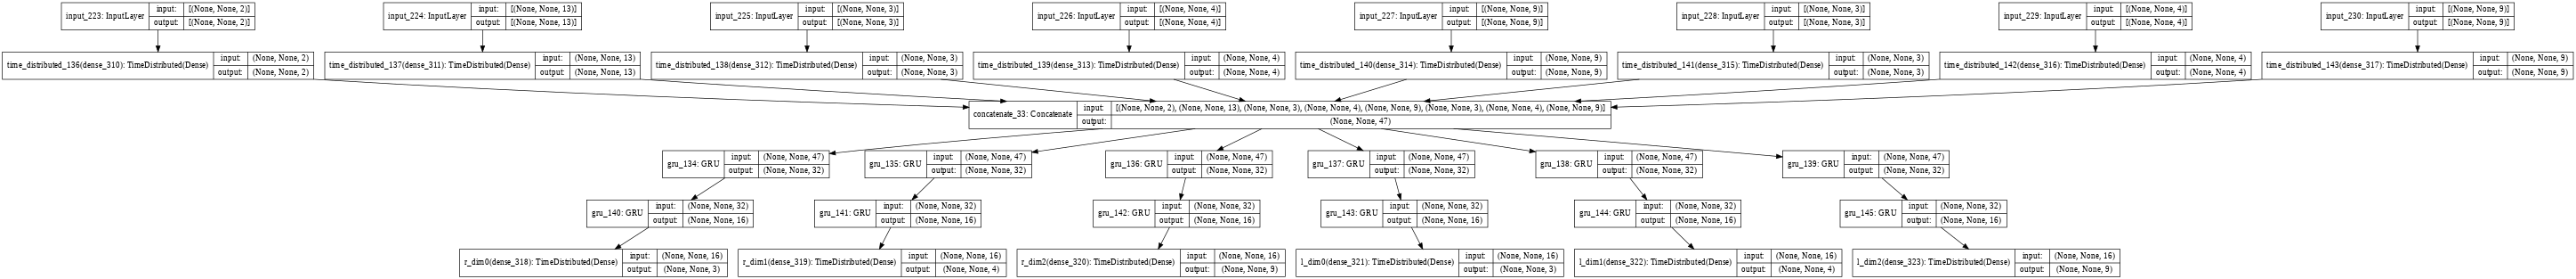

In [0]:
from tensorflow.keras.utils import plot_model

plot_model(model, show_shapes=True, dpi=48)

In [0]:
h = model.fit(x_t, y_t, batch_size=best_settings['batch_size'], epochs=150, validation_data=(x_v, y_v), callbacks=get_callbacks(settings), verbose=True, shuffle=True)

model.save(model_path)

Train on 13312 samples, validate on 3328 samples
Epoch 1/150
13312/13312 [==============================] - 24s 2ms/sample - loss: 7.2201 - r_dim0_loss: 0.7526 - r_dim1_loss: 1.2858 - r_dim2_loss: 1.5746 - l_dim0_loss: 0.7484 - l_dim1_loss: 1.3007 - l_dim2_loss: 1.5580 - r_dim0_accuracy: 0.6962 - r_dim1_accuracy: 0.4039 - r_dim2_accuracy: 0.4398 - l_dim0_accuracy: 0.6970 - l_dim1_accuracy: 0.3933 - l_dim2_accuracy: 0.4502 - val_loss: 6.5365 - val_r_dim0_loss: 0.6972 - val_r_dim1_loss: 1.2002 - val_r_dim2_loss: 1.3689 - val_l_dim0_loss: 0.6912 - val_l_dim1_loss: 1.2092 - val_l_dim2_loss: 1.3698 - val_r_dim0_accuracy: 0.7160 - val_r_dim1_accuracy: 0.4644 - val_r_dim2_accuracy: 0.5365 - val_l_dim0_accuracy: 0.7190 - val_l_dim1_accuracy: 0.4544 - val_l_dim2_accuracy: 0.5423
Epoch 2/150
 1280/13312 [=>............................] - ETA: 15s - loss: 6.5126 - r_dim0_loss: 0.6858 - r_dim1_loss: 1.1978 - r_dim2_loss: 1.3708 - l_dim0_loss: 0.6802 - l_dim1_loss: 1.2051 - l_dim2_loss: 1.3729 - r_